In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

### Скачиваю

In [66]:
districts_info = pd.read_csv('districts_info.csv', sep = '|')
user_routes_2019_2020 = pd.read_csv('user_routes_2019_2020.csv')
districts_info.head()

,area_id,region_name,area_name,centroid_lat,centroid_lon,neighbor_area_idx
0,504,Ivano-Frankivska,Nadvirnianskyi raion,48.629834,24.577387,"""[\""529\"", \""473\"", \""505\"", \""437\"", \""506\"",..."
1,505,Ivano-Frankivska,Bohorodchanskyi raion,48.807555,24.543633,"""[\""473\"", \""504\"", \""503\"", \""509\"", \""531\""]"""
2,506,Ivano-Frankivska,Yaremchanska mis'ka rada,48.455939,24.569405,"""[\""471\"", \""504\"", \""437\"", \""510\""]"""
3,507,Ivano-Frankivska,Ivano-Frankivska mis'ka rada,48.917401,24.710827,"""[\""473\""]"""
4,508,Zaporizka,Zaporizka mis'ka rada,47.845421,35.160531,"""[\""459\"", \""461\""]"""


In [67]:
print (len(districts_info))
print (len(user_routes_2019_2020))
len(np.unique(user_routes_2019_2020.user_id))

536
6997282


50000

### Перевожу даты и время в datetime

In [68]:
%%time
user_routes_2019_2020.start_time = pd.to_datetime(user_routes_2019_2020.start_time)
user_routes_2019_2020.finish_time = pd.to_datetime(user_routes_2019_2020.finish_time)
user_routes_2019_2020.hmonth = pd.to_datetime(user_routes_2019_2020.hmonth)
# выделяю год и месяц из даты
user_routes_2019_2020['month'] = user_routes_2019_2020['hmonth'].dt.month
user_routes_2019_2020['year'] = user_routes_2019_2020['hmonth'].dt.year

CPU times: user 3.58 s, sys: 202 ms, total: 3.78 s
Wall time: 3.96 s


In [69]:
# разница между finish_time и start_time
user_routes_2019_2020['time'] = (user_routes_2019_2020.finish_time - user_routes_2019_2020.start_time).dt.total_seconds()/3600

### Беру данные центров районов и считаю между ними расстояние для каждой поездки, но это не реальное расстояние поездки, а расстояние между центрами районов

In [70]:
user_routes_2019_2020 = user_routes_2019_2020.merge(districts_info[['area_id', 'centroid_lat', 'centroid_lon']], how = 'left', 
                                                   left_on='start_area_id', right_on='area_id')
user_routes_2019_2020 = user_routes_2019_2020.merge(districts_info[['area_id', 'centroid_lat', 'centroid_lon', 'region_name']], how = 'left', 
                                                   left_on='finish_area_id', right_on='area_id')
user_routes_2019_2020.head()

,user_id,start_area_id,finish_area_id,start_time,finish_time,hmonth,month,year,time,area_id_x,centroid_lat_x,centroid_lon_x,area_id_y,centroid_lat_y,centroid_lon_y,region_name
0,36453,492,417,2020-08-11 15:00:00,2020-08-11 16:00:00,2020-08-01,8,2020,1.0,492.0,50.449076,30.548499,417.0,50.520786,30.241856,Kyivska
1,42921,492,417,2020-09-01 22:00:00,2020-09-01 23:00:00,2020-09-01,9,2020,1.0,492.0,50.449076,30.548499,417.0,50.520786,30.241856,Kyivska
2,17307,526,435,2020-06-07 10:00:00,2020-06-07 13:00:00,2020-06-01,6,2020,3.0,526.0,48.180111,23.297680,435.0,48.316450,23.038723,Zakarpatska
3,24129,416,49,2019-04-21 19:00:00,2019-04-21 20:00:00,2019-04-01,4,2019,1.0,416.0,50.939211,29.896676,49.0,50.493534,29.239891,Zhytomyrska
4,10139,540,539,2020-05-01 06:00:00,2020-05-01 07:00:00,2020-05-01,5,2020,1.0,540.0,46.819380,35.421975,539.0,46.847440,35.360363,Zaporizka


In [71]:
def haversine(lat1, lon1, lat2, lon2):


    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, (lon1, lat1, lon2, lat2))

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

user_routes_2019_2020['distance'] = haversine(user_routes_2019_2020.centroid_lat_x, user_routes_2019_2020.centroid_lon_x, 
                                              user_routes_2019_2020.centroid_lat_y, user_routes_2019_2020.centroid_lon_y)

In [72]:
user_routes_2019_2020 = user_routes_2019_2020.drop(['area_id_x', 'area_id_y'], axis=1)
user_routes_2019_2020 = user_routes_2019_2020.dropna()

In [73]:
user_routes_2019_2020 = pd.concat([user_routes_2019_2020[user_routes_2019_2020['month']==4], user_routes_2019_2020[user_routes_2019_2020['month']==5]])

### Разбаваю на 2019 и 2020 год

In [74]:
user_routes_2019 = user_routes_2019_2020[user_routes_2019_2020.year == 2019]
user_routes_2020 = user_routes_2019_2020[user_routes_2019_2020.year == 2020]
user_routes_2019.head()

,user_id,start_area_id,finish_area_id,start_time,finish_time,hmonth,month,year,time,centroid_lat_x,centroid_lon_x,centroid_lat_y,centroid_lon_y,region_name,distance
3,24129,416,49,2019-04-21 19:00:00,2019-04-21 20:00:00,2019-04-01,4,2019,1.0,50.939211,29.896676,50.493534,29.239891,Zhytomyrska,67.736489
7,5418,93,29,2019-04-24 06:00:00,2019-04-24 07:00:00,2019-04-01,4,2019,1.0,51.620858,24.967457,51.761789,25.500003,Volynska,39.887985
19,19871,420,418,2019-04-04 21:00:00,2019-04-04 22:00:00,2019-04-01,4,2019,1.0,50.113514,30.630740,50.181053,30.329402,Kyivska,22.733152
24,8113,95,33,2019-04-05 19:00:00,2019-04-05 20:00:00,2019-04-01,4,2019,1.0,49.232889,28.476999,49.077161,27.678419,Vinnytska,60.563428
29,25633,221,492,2019-04-28 08:00:00,2019-04-28 09:00:00,2019-04-01,4,2019,1.0,50.913672,31.116157,50.449076,30.548499,Kyivska,65.291968


### Добавляю столбец количество уникальных районов которые посетил каждый юзер

In [75]:
user_routes_2019['no_areas']=user_routes_2019['user_id'].map(user_routes_2019.groupby('user_id')['start_area_id'].nunique())
user_routes_2020['no_areas']=user_routes_2020['user_id'].map(user_routes_2020.groupby('user_id')['start_area_id'].nunique())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Группирую данные по user_id и здесь пока 4 фичи: количество поездок, количество райнов в которые юзер ездит, условное расстояние за все время, потраченое время на дорогу общее

In [76]:
df_2019 = user_routes_2019.groupby('user_id').agg({'no_areas':'mean', 'distance':'sum', 'time':'sum'})
df_2020 = user_routes_2020.groupby('user_id').agg({'no_areas':'mean', 'distance':'sum', 'time':'sum'})
df_2019

,no_areas,distance,time
user_id,,,
1,3,1424.310022,79.0
2,5,1238.701403,45.0
3,7,2098.891412,121.0
4,5,2163.392787,15.0
5,2,316.117528,14.0
...,...,...,...
49995,2,136.976596,8.0
49996,2,36.334538,6.0
49997,3,313.591460,10.0


### Добавляем 2 фичи вне области и в области

In [77]:
df_routes_with_districts_2019 = user_routes_2019[['user_id', 'finish_area_id', 'region_name', 'finish_time']]
df_routes_with_districts_2020 = user_routes_2020[['user_id', 'finish_area_id', 'region_name', 'finish_time']]
df_routes_with_districts_2019.head()

,user_id,finish_area_id,region_name,finish_time
3,24129,49,Zhytomyrska,2019-04-21 20:00:00
7,5418,29,Volynska,2019-04-24 07:00:00
19,19871,418,Kyivska,2019-04-04 22:00:00
24,8113,33,Vinnytska,2019-04-05 20:00:00
29,25633,492,Kyivska,2019-04-28 09:00:00


In [78]:
df_routes_with_districts_2019['region_id'] = LabelEncoder().fit_transform(df_routes_with_districts_2019['region_name'].astype(str))
df_routes_with_districts_2020['region_id'] = LabelEncoder().fit_transform(df_routes_with_districts_2020['region_name'].astype(str))
df_routes_with_districts_2020.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,finish_area_id,region_name,finish_time,region_id
33,4033,35,Vinnytska,2020-04-25 16:00:00,19
34,26857,442,Zaporizka,2020-04-22 07:00:00,22
139,25837,36,Zhytomyrska,2020-04-14 08:00:00,23
176,3172,415,Kyivska,2020-04-17 23:00:00,10
184,26820,424,Dnipropetrovska,2020-04-12 10:00:00,3


In [79]:
region_id_counts_2019 = df_routes_with_districts_2019.groupby(['user_id', 'region_id']).size()
region_id_counts_2020 = df_routes_with_districts_2020.groupby(['user_id', 'region_id']).size()
region_id_counts_2019.head()

user_id  region_id
1        5            66
2        14           30
3        5             1
         10           70
4        10            6
dtype: int64

In [80]:
df_pivot_2019 = region_id_counts_2019.reset_index().pivot_table(values=0, index='user_id', columns='region_id').fillna(0).astype(int)
df_pivot_2020 = region_id_counts_2020.reset_index().pivot_table(values=0, index='user_id', columns='region_id').fillna(0).astype(int)
df_pivot_2019.head()

region_id,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,66,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,30,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
df_pivot_witout_max_2019 = df_pivot_2019.iloc[:].apply(lambda x: x.replace(x.max(), 0), axis=1)
df_pivot_witout_max_2020 = df_pivot_2020.iloc[:].apply(lambda x: x.replace(x.max(), 0), axis=1)

In [82]:
trips_2019 = pd.concat([df_pivot_witout_max_2019.sum(axis=1), user_routes_2019.groupby('user_id').size() - df_pivot_witout_max_2019.sum(axis=1)], axis=1)
trips_2019.columns = ['outside_district', 'inside_district']
trips_2020 = pd.concat([df_pivot_witout_max_2020.sum(axis=1), user_routes_2020.groupby('user_id').size() - df_pivot_witout_max_2020.sum(axis=1)], axis=1)
trips_2020.columns = ['outside_district', 'inside_district']
trips_2019

,outside_district,inside_district
user_id,,
1,0,66
2,0,30
3,1,70
4,5,6
5,0,14
...,...,...
49995,0,8
49996,0,6
49997,2,6


In [83]:
df_2019 = pd.concat([df_2019, trips_2019], axis=1)
df_2020 = pd.concat([df_2020, trips_2020], axis=1)
df_2019 = df_2019[['no_areas', 'distance', 'time', 'outside_district', 'inside_district']]
df_2020 = df_2020[['no_areas', 'distance', 'time', 'outside_district', 'inside_district']]
df_2020

,no_areas,distance,time,outside_district,inside_district
user_id,,,,,
1,3,469.400518,36.0,0,23
2,4,1822.044789,79.0,0,62
3,3,772.580151,42.0,0,32
4,6,572.318443,8.0,3,5
5,3,495.905871,20.0,0,20
...,...,...,...,...,...
49996,2,12.111513,2.0,0,2
49997,2,26.867541,2.0,0,2
49998,2,137.635797,3.0,0,2


### Нормализирую данные, беру все 4 фичи, беру 4 класстера

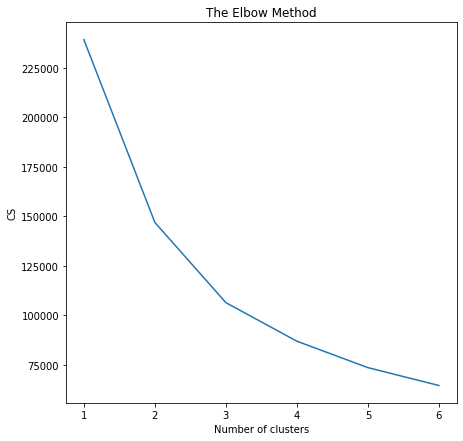

In [84]:
X = StandardScaler().fit_transform(df_2019)

cs = []
for i in range(1, 7):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.figure(figsize=(7, 7))
plt.plot(range(1, 7), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [324]:
X_embedded = TSNE(n_components=2, verbose=True).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.064s...
[t-SNE] Computed neighbors for 50000 samples in 2.721s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sam

In [85]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
kmeans.labels_

array([3, 1, 3, ..., 1, 1, 1], dtype=int32)

In [326]:
x = X_embedded[:, 0]
y = X_embedded[:, 1]

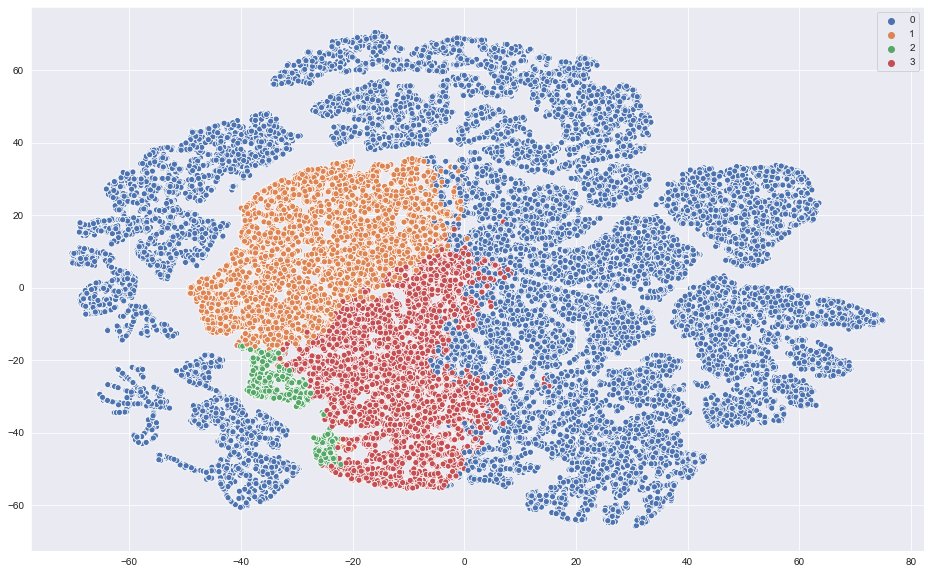

In [327]:
import seaborn as sns
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid")
sns.scatterplot(x=x.tolist(), y=y.tolist(), hue=kmeans.labels_, palette='deep');

In [38]:
X_embedded2 = PCA(n_components=2).fit_transform(X)

In [39]:
x2 = X_embedded2[:, 0]
y2 = X_embedded2[:, 1]

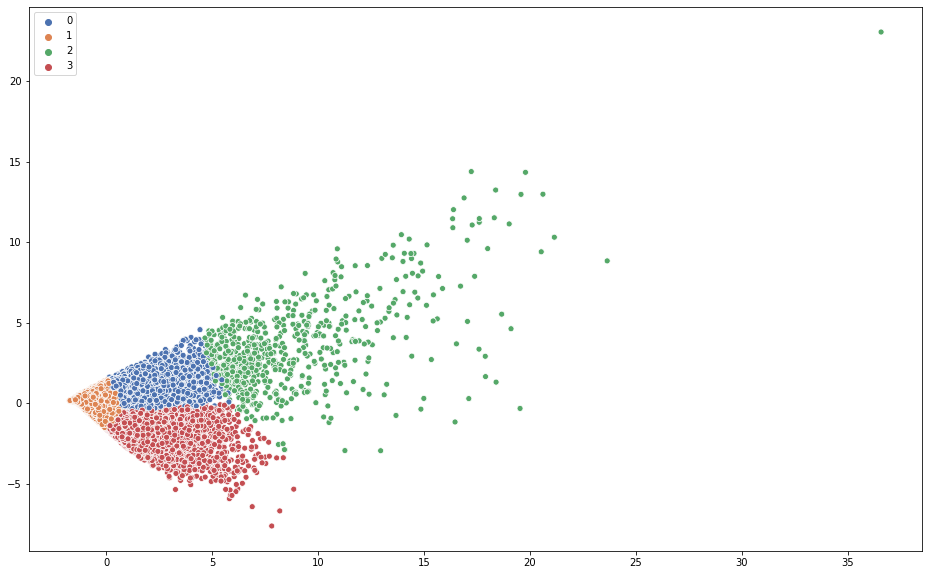

In [40]:
import seaborn as sns
plt.figure(figsize=(16, 10))
sns.scatterplot(x=x2.tolist(), y=y2.tolist(), hue=kmeans.labels_, palette='deep');

In [86]:
df_2019['cluster'] = kmeans.labels_
df_2019.head()

,no_areas,distance,time,outside_district,inside_district,cluster
user_id,,,,,,
1,3,1424.310022,79.0,0,66,3
2,5,1238.701403,45.0,0,30,1
3,7,2098.891412,121.0,1,70,3
4,5,2163.392787,15.0,5,6,0
5,2,316.117528,14.0,0,14,1


In [87]:
zero_numbering = {1:0, 3:1, 2:2, 0:3}
df_2019['cluster'] = df_2019['cluster'].apply(lambda x: zero_numbering[x])

In [88]:
df_2019.cluster.value_counts()

0    34862
1     7004
3     5293
2      689
Name: cluster, dtype: int64

In [89]:
s = df_2019.groupby(['cluster']).mean()
s

,no_areas,distance,time,outside_district,inside_district
cluster,,,,,
0,3.190523,535.232894,16.918479,0.663186,11.921060
1,4.265848,2212.904834,103.069103,1.082524,72.410337
2,18.000000,7345.850591,181.606676,32.052250,41.210450
3,7.297941,2224.272207,55.889288,8.945022,21.952012


In [90]:
s['quantity'] = [34862, 7004, 689, 5293]
s

,no_areas,distance,time,outside_district,inside_district,quantity
cluster,,,,,,
0,3.190523,535.232894,16.918479,0.663186,11.921060,34862
1,4.265848,2212.904834,103.069103,1.082524,72.410337,7004
2,18.000000,7345.850591,181.606676,32.052250,41.210450,689
3,7.297941,2224.272207,55.889288,8.945022,21.952012,5293


### Предсказываю для 2020

In [91]:
X_2020 = StandardScaler().fit_transform(df_2020)
df_2020['cluster'] = kmeans.predict(X_2020)
df_2020.head()

,no_areas,distance,time,outside_district,inside_district,cluster
user_id,,,,,,
1,3,469.400518,36.0,0,23,1
2,4,1822.044789,79.0,0,62,3
3,3,772.580151,42.0,0,32,1
4,6,572.318443,8.0,3,5,1
5,3,495.905871,20.0,0,20,1


In [93]:
zero_numbering = {1:0, 3:1, 2:2, 0:3}
df_2020['cluster'] = df_2020['cluster'].apply(lambda x: zero_numbering[x])

In [94]:
df_2020.groupby(['cluster']).mean()

,no_areas,distance,time,outside_district,inside_district
cluster,,,,,
0,2.657415,364.828496,13.267632,0.283315,10.053942
1,3.586741,1950.611176,100.513687,0.553760,67.413094
2,15.387205,6839.624107,184.158249,30.782828,41.237374
3,6.113043,1745.541321,51.256942,7.268724,21.596073


In [95]:
df_2020.cluster.value_counts()

0    33221
1     6064
3     3565
2      594
Name: cluster, dtype: int64

In [96]:
z=df_2020.groupby(['cluster']).mean()
z['quantity'] = [33221, 6064, 594, 3565]
z

,no_areas,distance,time,outside_district,inside_district,quantity
cluster,,,,,,
0,2.657415,364.828496,13.267632,0.283315,10.053942,33221
1,3.586741,1950.611176,100.513687,0.553760,67.413094,6064
2,15.387205,6839.624107,184.158249,30.782828,41.237374,594
3,6.113043,1745.541321,51.256942,7.268724,21.596073,3565


In [97]:
s

,no_areas,distance,time,outside_district,inside_district,quantity
cluster,,,,,,
0,3.190523,535.232894,16.918479,0.663186,11.921060,34862
1,4.265848,2212.904834,103.069103,1.082524,72.410337,7004
2,18.000000,7345.850591,181.606676,32.052250,41.210450,689
3,7.297941,2224.272207,55.889288,8.945022,21.952012,5293


In [340]:
X_embedded2020 = PCA(n_components=2).fit_transform(X_2020)
x2020 = X_embedded2020[:, 0]
y2020 = X_embedded2020[:, 1]

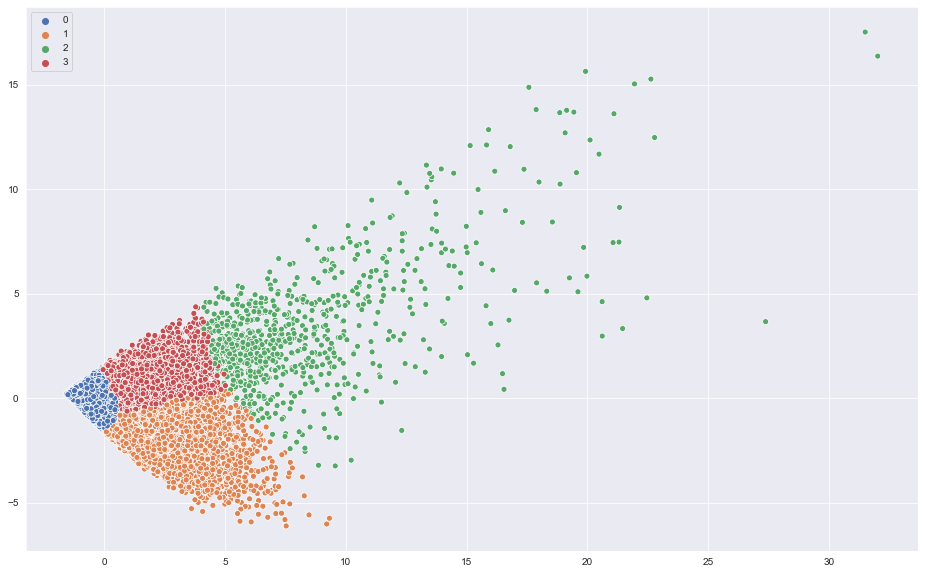

In [341]:
import seaborn as sns
plt.figure(figsize=(16, 10))
sns.scatterplot(x=x2020.tolist(), y=y2020.tolist(), hue=kmeans.predict(X_2020), palette='deep');

# Для Ужгорода

In [342]:
routs_uz = pd.read_csv('user_routes_Uzhhorod.csv')
routs_uz['start_time'] = pd.to_datetime(routs_uz.start_time)
routs_uz['finish_time'] = pd.to_datetime(routs_uz.finish_time)
routs_uz['hmonth'] = pd.to_datetime(routs_uz.hmonth)
routs_uz['month'] = routs_uz['hmonth'].dt.month
routs_uz['year'] = routs_uz['hmonth'].dt.year
routs_uz

,user_id,start_time,start_area_id,finish_time,finish_area_id,hmonth,month,year
0,102493,2019-06-09 14:00:00,526,2019-06-09 15:00:00,434,2019-06-01,6,2019
1,102493,2019-06-12 20:00:00,434,2019-06-12 21:00:00,526,2019-06-01,6,2019
2,102493,2019-06-18 14:00:00,526,2019-06-18 15:00:00,435,2019-06-01,6,2019
3,102493,2019-06-18 17:00:00,435,2019-06-18 19:00:00,526,2019-06-01,6,2019
4,102493,2019-06-20 14:00:00,526,2019-06-20 19:00:00,528,2019-06-01,6,2019
...,...,...,...,...,...,...,...,...
335257,142958,2019-04-29 02:00:00,157,2019-04-29 10:00:00,528,2019-04-01,4,2019
335258,142958,2019-04-29 16:00:00,528,2019-04-29 23:00:00,522,2019-04-01,4,2019
335259,142958,2019-04-30 04:00:00,522,2019-04-30 06:00:00,419,2019-04-01,4,2019
335260,142958,2019-04-30 08:00:00,419,2019-04-30 09:00:00,492,2019-04-01,4,2019


In [343]:
routs_uz = routs_uz.merge(districts_info[['area_id', 'centroid_lat', 'centroid_lon']], how = 'left', 
                                                   left_on='start_area_id', right_on='area_id')
routs_uz = routs_uz.merge(districts_info[['area_id', 'centroid_lat', 'centroid_lon', 'region_name']], how = 'left', 
                                                   left_on='finish_area_id', right_on='area_id')
routs_uz = routs_uz.drop(['area_id_x', 'area_id_y'], axis=1)
routs_uz = routs_uz.dropna()
routs_uz.head()

,user_id,start_time,start_area_id,finish_time,finish_area_id,hmonth,month,year,centroid_lat_x,centroid_lon_x,centroid_lat_y,centroid_lon_y,region_name
0,102493,2019-06-09 14:00:00,526,2019-06-09 15:00:00,434,2019-06-01,6,2019,48.180111,23.297680,48.145555,23.031692,Zakarpatska
1,102493,2019-06-12 20:00:00,434,2019-06-12 21:00:00,526,2019-06-01,6,2019,48.145555,23.031692,48.180111,23.297680,Zakarpatska
2,102493,2019-06-18 14:00:00,526,2019-06-18 15:00:00,435,2019-06-01,6,2019,48.180111,23.297680,48.316450,23.038723,Zakarpatska
3,102493,2019-06-18 17:00:00,435,2019-06-18 19:00:00,526,2019-06-01,6,2019,48.316450,23.038723,48.180111,23.297680,Zakarpatska
4,102493,2019-06-20 14:00:00,526,2019-06-20 19:00:00,528,2019-06-01,6,2019,48.180111,23.297680,48.433610,22.201144,Zakarpatska


In [344]:
routs_uz['no_areas']=routs_uz['user_id'].map(routs_uz.groupby('user_id')['start_area_id'].nunique())
routs_uz['distance'] = haversine(routs_uz.centroid_lat_x, routs_uz.centroid_lon_x, 
                                              routs_uz.centroid_lat_y, routs_uz.centroid_lon_y)
routs_uz['time'] = (routs_uz.finish_time - routs_uz.start_time).dt.total_seconds()/3600
df_uz = routs_uz.groupby('user_id').agg({'no_areas':'mean', 'distance':'sum', 'time':'sum'})
df_uz

,no_areas,distance,time
user_id,,,
100275,3,282.324441,13.0
100276,7,1927.739355,67.0
100277,3,1352.191166,45.0
100278,2,120.965783,2.0
100279,5,1810.354274,72.0
...,...,...,...
155892,6,1460.498029,56.0
155893,6,2085.218896,62.0
155894,4,627.605759,17.0


In [345]:
df_routes_with_districts_uz = routs_uz[['user_id', 'finish_area_id', 'region_name', 'finish_time']]
df_routes_with_districts_uz['region_id'] = LabelEncoder().fit_transform(df_routes_with_districts_uz['region_name'].astype(str))
region_id_counts_uz = df_routes_with_districts_uz.groupby(['user_id', 'region_id']).size()
df_pivot_uz = region_id_counts_uz.reset_index().pivot_table(values=0, index='user_id', columns='region_id').fillna(0).astype(int)
df_pivot_witout_max_uz = df_pivot_uz.iloc[:].apply(lambda x: x.replace(x.max(), 0), axis=1)
trips_uz = pd.concat([df_pivot_witout_max_uz.sum(axis=1), routs_uz.groupby('user_id').size() - df_pivot_witout_max_uz.sum(axis=1)], axis=1)
trips_uz.columns = ['outside_district', 'inside_district']
df_uz = pd.concat([df_uz, trips_uz], axis=1)
df_uz = df_uz[['no_areas', 'distance', 'time', 'outside_district', 'inside_district']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [346]:
X_uz = StandardScaler().fit_transform(df_uz)
df_uz['cluster'] = kmeans.predict(X_uz)
df_uz.head()

,no_areas,distance,time,outside_district,inside_district,cluster
user_id,,,,,,
100275,3,282.324441,13.0,0,10,0
100276,7,1927.739355,67.0,0,36,0
100277,3,1352.191166,45.0,0,41,0
100278,2,120.965783,2.0,0,2,0
100279,5,1810.354274,72.0,2,24,0


In [347]:
df_uz.groupby(['cluster']).mean()

,no_areas,distance,time,outside_district,inside_district
cluster,,,,,
0,5.615735,1601.057025,50.232482,1.824943,26.903112
1,9.173729,7488.659026,349.885593,4.673729,199.820621
2,41.382812,25527.364006,593.789062,87.585938,86.531250
3,17.243570,7961.363989,200.685325,23.576399,59.072617


In [348]:
df_uz.cluster.value_counts()

0    3953
1     708
3     661
2     128
Name: cluster, dtype: int64

In [415]:
StandardScaler().fit_transform(a)

array([[-0.83373018, -0.98232796, -1.16807681, -0.77405987, -1.05572584],
       [-0.6774192 , -0.28944751,  0.28255852, -0.73508901,  1.54471461],
       [ 1.67867029,  1.6709108 ,  1.48287595,  1.68239724,  0.19124906],
       [-0.16752092, -0.39913533, -0.59735766, -0.17324836, -0.68023784]])

In [416]:
StandardScaler().fit_transform(b)

array([[-0.82498794, -0.96477709, -1.14882154, -0.76203731, -1.08247854],
       [-0.67058957, -0.27830701,  0.26417696, -0.72553914,  1.52971119],
       [ 1.68355809,  1.67489891,  1.49567921,  1.6888941 ,  0.2169602 ],
       [-0.18798058, -0.4318148 , -0.61103462, -0.20131764, -0.66419286]])

In [51]:
a=df_2019.groupby(['cluster']).mean()
a
#np.round((a-a.mean())/a.std(), 2)

,no_areas,distance,time,outside_district,inside_district
cluster,,,,,
0,7.297941,2224.272207,55.889288,8.945022,21.952012
1,3.190523,535.232894,16.918479,0.663186,11.921060
2,18.000000,7345.850591,181.606676,32.052250,41.210450
3,4.265848,2212.904834,103.069103,1.082524,72.410337


In [52]:
b=df_2020.groupby(['cluster']).mean()
b
#np.round((b-b.mean())/b.std(), 2)

,no_areas,distance,time,outside_district,inside_district
cluster,,,,,
0,6.113043,1745.541321,51.256942,7.268724,21.596073
1,2.657415,364.828496,13.267632,0.283315,10.053942
2,15.387205,6839.624107,184.158249,30.782828,41.237374
3,3.586741,1950.611176,100.513687,0.553760,67.413094


In [98]:
# no_areas
import plotly.graph_objects as go

categories = ['cluster 0','cluster 1','cluster 2', 'cluster 3']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      #r=list(a.no_areas),
      r=[100,100,100,100],
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      #r=list(b.no_areas),
      r=[83, 84, 85, 83.6],

      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  showlegend=False
)

fig.show()

In [99]:
#distance
import plotly.graph_objects as go

categories = ['cluster 0','cluster 1','cluster 2', 'cluster 3']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      #r=list(a.no_areas),
      r=[100,100,100,100],
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      #r=list(b.no_areas),
      r=[68, 88, 93, 78],
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  showlegend=False
)

fig.show()

In [100]:
# time
import plotly.graph_objects as go

categories = ['cluster 0','cluster 1','cluster 2', 'cluster 3']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      #r=list(a.no_areas),
      r=[100,100,100,100],
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      #r=list(b.no_areas),
      r=[76.8, 97.5, 101.4, 91],
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 110]
    )),
  showlegend=False
)

fig.show()

In [101]:
# outside
import plotly.graph_objects as go

categories = ['cluster 0','cluster 1','cluster 2', 'cluster 3']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      #r=list(a.no_areas),
      r=[100,100,100,100],
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      #r=list(b.no_areas),
      r=[42, 51, 96, 81],
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  showlegend=False
)

fig.show()

In [102]:
# inside
import plotly.graph_objects as go

categories = ['cluster 0','cluster 1','cluster 2', 'cluster 3']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      #r=list(a.no_areas),
      r=[100,100,100,100],
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      #r=list(b.no_areas),
      r=[84.3, 93, 100, 98.35],
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  showlegend=False
)

fig.show()

In [59]:
# quantity
import plotly.graph_objects as go

categories = ['cluster 0','cluster 1','cluster 2', 'cluster 3']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      #r=list(a.no_areas),
      r=[100,100,100,100],
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      #r=list(b.no_areas),
      r=[67.35, 95.29, 86, 115.5],
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 120]
    )),
  showlegend=False
)

fig.show()

In [431]:
df_2019

,no_areas,distance,time,outside_district,inside_district,cluster
user_id,,,,,,
1,6,4354.991962,225.0,2,188,1
2,5,2694.458402,112.0,0,89,0
3,11,5720.768884,316.0,6,187,1
4,10,5304.098613,59.0,15,34,3
5,2,1580.587641,72.0,0,70,0
...,...,...,...,...,...,...
49996,3,472.674792,23.0,1,15,0
49997,4,527.832003,23.0,7,13,0
49998,6,680.819037,11.0,1,9,0


# Моє доповнення

In [ ]:
df

In [ ]:
user_routes_2019.head()

In [ ]:
df_routes_with_districts = user_routes_2019[['user_id', 'finish_area_id', 'region_name', 'finish_time']]
df_routes_with_districts.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_routes_with_districts['region_id'] = LabelEncoder().fit_transform(df_routes_with_districts['region_name'].astype(str))
df_routes_with_districts['region_id'] = LabelEncoder().fit_transform(df_routes_with_districts['region_name'].astype(str))
df_routes_with_districts.head()

In [ ]:
region_id_counts = df_routes_with_districts.groupby(['user_id', 'region_id']).size()
region_id_counts.head()

In [ ]:
df_pivot = region_id_counts.reset_index().pivot_table(values=0, index='user_id', columns='region_id').fillna(0).astype(int)
df_pivot.head()

In [ ]:
df_pivot_witout_max = df_pivot.iloc[:].apply(lambda x: x.replace(x.max(), 0), axis=1)

In [ ]:
trips = pd.concat([df_pivot_witout_max.sum(axis=1), user_routes_2019.groupby('user_id').size() - df_pivot_witout_max.sum(axis=1)], axis=1)
trips.columns = ['outside', 'inside']
trips

In [ ]:
full_df = pd.concat([df, trips], axis=1)
full_df = full_df[['no_trips', 'no_districts', 'distance', 'time', 'outside', 'inside']]
full_df

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=True).fit_transform(full_df)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42).fit(full_df)
kmeans.labels_

In [ ]:
x = X_embedded[:, 0]
y = X_embedded[:, 1]

In [ ]:
import seaborn as sns
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid")
sns.scatterplot(x=x.tolist(), y=y.tolist(), hue=kmeans.labels_, palette='deep');

In [ ]:
from sklearn.decomposition import PCA
X_embedded2 = PCA(n_components=2).fit_transform(full_df)

In [ ]:
x2 = X_embedded2[:, 0]
y2 = X_embedded2[:, 1]

In [ ]:
import seaborn as sns
plt.figure(figsize=(16, 10))
sns.scatterplot(x=x2.tolist(), y=y2.tolist(), hue=kmeans.labels_, palette='deep');

In [ ]:
full_df['label'] = kmeans.labels_
full_df.head()

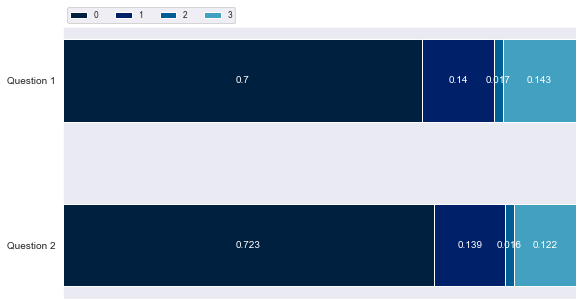

In [396]:
import numpy as np
import matplotlib.pyplot as plt


category_names = [0, 1, 2, 3]
results = {
    'Question 1': [0.7, 0.14, 0.017, 0.143],
    'Question 2': [0.723, 0.139, 0.016, 0.122],
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    #category_colors = plt.get_cmap('RdYlGn')(
    category_colors = plt.get_cmap('ocean')(
        np.linspace(0.25, 0.75, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(c), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.show()

In [390]:
z['quantity'][2]/z['quantity'].sum()*100

1.6320652826113045